# **Install Dependencies**

In [ ]:
!pip install miditok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.9 MB/s eta 0:00:00


# **Import Dependencies**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from miditok import REMIPlus
from miditok.utils import get_midi_programs
from miditoolkit import MidiFile
import matplotlib.pyplot as plt
from IPython.display import clear_output, display, HTML
from IPython.core import display as ipydisplay
from collections import OrderedDict
import time
import gc
from tqdm import tqdm
import copy
from collections import defaultdict
import os
import logging
import pickle
import datetime
import json
import gc
import random

# **Utils**

---
## **Function**: `train_one_epoch`
---

**Description**:
Trains the model for one epoch and optionally performs evaluation at specified intervals. Keeps track of training and validation losses and saves model checkpoints.

**Parameters**:
- `model` (nn.Module): The model to be trained.
- `optimizer` (Optimizer): Optimizer for updating model weights.
- `dataloader` (DataLoader): DataLoader object for training data.
- `device` (torch.device): Device to move data to (e.g., cuda, cpu).
- `epoch` (int): Current training epoch.
- `parameters` (dict): Additional parameters like learning rate, etc.
- `eval_interval` (int): Interval at which to perform evaluation and save model checkpoints.
- `eval_dataloader` (DataLoader, optional): DataLoader object for evaluation data.

**Returns**:
- `float`: The average loss for the epoch.

In [ ]:
def train_one_epoch(model, optimizer, dataloader, device, epoch, parameters, eval_interval, eval_dataloader=None):
    model.train()

    dataset_size = 0
    running_loss = 0.0

    train_losses = []
    val_losses = []

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        x = data['x'].to(device)
        y = data['y'].to(device)

        batch_size = x.size(0)

        logits,loss = model.forward(x,y)

        if loss.numel() > 1:
            loss = loss.mean()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, LR=optimizer.param_groups[0]['lr'])
        if step % eval_interval == 0:
            train_losses.append(epoch_loss)
            val_losses.append(epoch_loss)

            plot_and_save(step, train_losses, val_losses, FILE_NAME, parameters, EMBED_DIM, TRANSFORMER_HEADS, TRANSFORMER_LAYERS)

            # Save the model after evaluation
            model_save_name = f"{FILE_NAME}_e_{epoch}_s_{step}.pt"
            torch.save(model.state_dict(), os.path.join(MODEL_DIR, model_save_name))
    gc.collect()
    return epoch_loss

---
## **Function**: `valid_one_epoch`
---

**Description**:
Validates the model for one epoch. Optionally, can run without tqdm progress bar for evaluation purposes.

**Parameters**:
- `model` (nn.Module): The model to be validated.
- `optimizer` (Optimizer): Optimizer for updating model weights (used for learning rate display).
- `dataloader` (DataLoader): DataLoader object for validation data.
- `device` (torch.device): Device to move data to (e.g., cuda, cpu).
- `epoch` (int): Current validation epoch.
- `evaluation` (bool, optional): Flag to disable tqdm progress bar.

**Returns**:
- `float`: The average loss for the epoch on validation data.

In [ ]:
def valid_one_epoch(model, optimizer, dataloader, device, epoch, evaluation=False):
    model.eval()

    dataset_size = 0
    running_loss = 0.0

    if not evaluation:
        bar = tqdm(enumerate(dataloader), total=len(dataloader))
    else:
        bar = enumerate(dataloader)
    epoch_loss = 0
    with torch.no_grad():
        for step, data in bar:
            x = data['x'].to(device)
            y = data['y'].to(device)

            batch_size = x.size(0)

            logits, loss = model.forward(x, y)

            running_loss += loss.item()
            dataset_size += batch_size

            epoch_loss = running_loss / dataset_size

            if not evaluation:
                bar.set_postfix(Epoch=epoch, Val_Loss=epoch_loss,
                                LR=optimizer.param_groups[0]['lr'])
    return epoch_loss

# **MidiDataset**

---
## **Class**: `MidiDataset`
---

**Description**:
Dataset class that loads MIDI files into tensors to create the dataset

**Methods**:
- `__init__(self, df)`: Initializes the MidiDataset.
  - `df` (DataFrame): DataFrame containing file names and other metadata.
- `__len__(self)`: Returns the length of the dataset.
- `__getitem__(self, idx)`: Gets the item at a specific index.
  - `idx` (int): The global index to retrieve.

**Returns for `__getitem__`**:
- `dict`: A dictionary containing the following key-value pairs:
  - `"x"`: The input tensor (shape `[SEQ_LEN, *]`).
  - `"y"`: The target tensor (shape `[SEQ_LEN, *]`).

In [ ]:
class MidiDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.indices = {}

        globalIndex = 0
        for fileIndex, row in df.iterrows():
            fname = ENCODING_DIR + "/" + row["fname"]
            if not os.path.exists(fname):
                continue
            with open(fname, 'rb') as f:
                nparray = np.load(f)
            for arrayIndex in range(nparray.shape[0] - SEQ_LEN):
                self.indices[globalIndex] = {
                    'file': fname,
                    'arrayIndex': arrayIndex
                }
                globalIndex += 1

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        fname = self.indices[idx]['file']
        arrayIndex = self.indices[idx]['arrayIndex']
        with open(fname, 'rb') as f:
            nparray = np.load(f)
        x = nparray[arrayIndex:arrayIndex+SEQ_LEN]
        y = nparray[arrayIndex+1:arrayIndex+SEQ_LEN+1]

        x = torch.tensor(x, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.long)
        return {"x": x, "y": y}

# **Transformer Model**

---
## **Class**: `AttentionHead`
---

**Description**:
Single head of the self-attention mechanism in Transformer model. Part of multi-head attention.

**Methods**:
- `__init__(self, head_size, num_embed, block_size)`: Initializes the AttentionHead module.
  - `head_size` (int): The dimension of each attention head.
  - `num_embed` (int): The dimension of the input embeddings.
  - `block_size` (int): The block size of the input sequence (maximum sequence length).
- `forward(self, x)`: Performs the forward pass.
  - `x` (Tensor): Input tensor of shape `(B, T, C)`.

**Returns for `forward`**:
- `Tensor`: The output tensor of shape `(B, T, C)`.


In [ ]:
class AttentionHead(nn.Module):
    def __init__(self, head_size, num_embed, block_size):
        super().__init__()

        self.key = nn.Linear(num_embed, head_size, bias=False)
        self.query = nn.Linear(num_embed, head_size, bias=False)
        self.value = nn.Linear(num_embed, head_size, bias=False)
        # tril is a lower triangular matrix. it is not a parameter
        # of the model, so we assign it to the module using register_buffer
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        # compute attention scores
        # (B, T, C) @ (B, C, T) -> (B, T, T)
        # we need to transpose k to match q
        wei = q @ k.transpose(-2, -1) * C**-0.5
        # Tril matrix (lower triagular matrix) is used to mask
        # future positions (setting them to -inf) so that the
        # decoder "learns" to predict next words
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))  # (B,T,T)
        wei = F.softmax(wei, dim=-1)  # (B,T,T)
        # weighted aggregation of the values
        v = self.value(x)
        out = wei @ v  # (B,T,T) @ (B,T,C) ---> (B,T,C)
        return out

---
## **Class**: `MultiHeadAttention`
---

**Description**:
Multi-head self-attention mechanism in Transformer model. Combines multiple `AttentionHead` modules in parallel and applies a linear projection.

**Attributes**:
- `heads`: A list of `AttentionHead` modules.
- `proj`: Linear layer for projecting the concatenated attention head outputs back to the input dimension.

**Methods**:
- `__init__(self, num_heads, head_size, num_embed, block_size)`: Initializes the MultiHeadAttention module.
  - `num_heads` (int): The number of attention heads.
  - `head_size` (int): The dimension of each attention head.
  - `num_embed` (int): The dimension of the input embeddings.
  - `block_size` (int): The block size of the input sequence (maximum sequence length).
- `forward(self, x)`: Performs the forward pass.
  - `x` (Tensor): Input tensor of shape `(B, T, C)`.

**Returns for `forward`**:
- `Tensor`: The output tensor of shape `(B, T, C)`.

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size, num_embed, block_size):
        super().__init__()
        self.heads = nn.ModuleList(
            [
                AttentionHead(
                    head_size=head_size,
                    num_embed=num_embed,
                    block_size=block_size,
                )
                for _ in range(num_heads)
            ]
        )
        self.proj = nn.Linear(num_embed, num_embed)

    def forward(self, x):
        # output of the self-attention

        out = torch.cat([h(x) for h in self.heads], dim=-1)
         # (B, T, num_heads * head_size)
        # apply the linear projection layer
        out = self.proj(out)
        # (B, T, num_embed)
        return out

---
## **Class**: `FeedForward`
---

**Description**:
Feed-forward neural network layer. Linear transformation followed by a ReLU activation then additional linear layer.

**Methods**:
- `__init__(self, num_embed)`: Initializes the FeedForward module.
  - `num_embed` (int): The dimension of the input embeddings.
- `forward(self, x)`: Performs the forward pass.
  - `x` (Tensor): Input tensor of shape `(B, T, C)`.

**Returns for `forward`**:
- `Tensor`: The output tensor of shape `(B, T, C)`.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, num_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_embed, 4 * num_embed),
            nn.ReLU(),

            nn.Linear(4 * num_embed, num_embed),
        )

    def forward(self, x):
        return self.net(x)

---
## **Class**: `TransformerBlock`
---

**Description**:
Single block in a Transformer model.

**Methods**:
- `__init__(self, num_heads, block_size, num_embed)`: Initializes the TransformerBlock.
  - `num_heads` (int): The number of attention heads.
  - `block_size` (int): The block size of the input sequence.
  - `num_embed` (int): The dimension of the input embeddings.
- `forward(self, x)`: Performs the forward pass.
  - `x` (Tensor): Input tensor of shape `(B, T, C)`.


In [ ]:
class TransformerBlock(nn.Module):

    def __init__(self, num_heads, block_size, num_embed):
        super().__init__()
        head_size = num_embed // num_heads
        self.sa = MultiHeadAttention(
            num_heads=num_heads,
            head_size=head_size,
            num_embed=num_embed,
            block_size=block_size,
        )
        self.ffwd = FeedForward(num_embed=num_embed)
        # add the layer normalization
        self.ln1 = nn.LayerNorm(num_embed)
        self.ln2 = nn.LayerNorm(num_embed)

    def forward(self, x):

        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

---
## **Class**: `Transformer`
---

**Description**:
Comprises multiple `TransformerBlock` units, token and position embeddings, and a linear output layer for language modeling.

**Methods**:
- `__init__(self, **kwargs)`: Initializes the Transformer model with optional keyword arguments.
- `forward(self, idx, targets=None)`: Performs the forward pass and optionally computes the loss.
  - `idx` (Tensor): Input token indices. Shape `(B, T)`.
  - `targets` (Tensor, optional): Ground truth token indices. Used for loss computation.
- `generate(self, idx, max_new_tokens, block_size)`: Generates a sequence given an input context.
  - `idx` (Tensor): Input token indices. Shape `(B, T)`.
  - `max_new_tokens` (int): Maximum number of new tokens to generate.
  - `block_size` (int): Length of the block to consider for generation.

**Returns for `forward`**:
- `Tuple`: Consists of `logits` (Tensor) and `loss` (float or None).

**Returns for `generate`**:
- `Tensor`: Generated sequence of tokens.

In [ ]:

class Transformer(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.vocab_size = kwargs.get("vocab_size", 100)
        self.num_embed = kwargs.get("num_embed", 32)
        self.block_size = kwargs.get("block_size", 8)
        self.num_heads = kwargs.get("num_heads", 4)
        self.num_layers = kwargs.get("num_layers", 4)
        # each token reads the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(self.vocab_size, self.num_embed)
        # each position from 0 to block_size-1 will get its embedding
        self.position_embedding_table = nn.Embedding(self.block_size, self.num_embed)
        self.blocks = nn.Sequential(
            *[
                TransformerBlock(
                    num_heads=self.num_heads,
                    block_size=self.block_size,
                    num_embed=self.num_embed,
                )
                for _ in range(self.num_layers)
            ]
        )
        # we add the layer norm before the Linear layer
        self.ln_f = nn.LayerNorm(self.num_embed)
        self.lm_head = nn.Linear(self.num_embed, self.vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are (B,T) tensor of integers
        # the token_emb is (B, T, C), C = NUM_EMBED
        token_emb = self.token_embedding_table(idx)
        # (T, C)
        posit_emb = self.position_embedding_table(torch.arange(T, device=DEVICE))

        x = token_emb + posit_emb
        # apply one head of self-attention
        x = self.blocks(x)
        # (B, T, vocab_size)
        logits = self.lm_head(x)
        # compute the loss
        if targets != None:

            B, T, C = logits.shape
            logits = torch.reshape(logits, (B * T, C))
            targets = torch.reshape(targets, (B * T,))
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None
        return logits, loss

    def generate(self, idx: torch.Tensor, max_new_tokens: int, block_size: int):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop the context too the  last block_size tokens
            # because tokens don't communicate between blocks
            idx_crop = idx[:, -block_size:]
            # get the predictions
            logits, loss = self.forward(idx_crop)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution with probabilities probs
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx

# **Train**

---
## **Function**: `save_training_info`
---

**Description**:
Saves the training and validation loss information along with hyperparameters and model details into a text file.

In [ ]:
def save_training_info(train_losses, val_losses, text_file_name, learning_rate, dropout):
    text_file_name = text_file_name + ".txt"
    with open(f'data_plots/{text_file_name}', 'w') as f:
        f.write("Model Information:\n")
        f.write("===================\n")
        f.write(f"File Name: {text_file_name}\n")
        f.write(f"Batch Size: {BATCH_SIZE}\n")
        f.write(f"Block Size: {SEQ_LEN}\n")
        f.write(f"Max Iterations: {0}\n")
        f.write(f"Learning Rate: {LR}\n")
        f.write(f"Device: {DEVICE}\n")
        f.write(f"Embedding Dimension: {EMBED_DIM}\n")
        f.write(f"Number of Attention Heads: {TRANSFORMER_HEADS}\n")
        f.write(f"Number of Layers: {TRANSFORMER_LAYERS}\n")
        f.write(f"Dropout Rate: {dropout}\n")
        f.write("\nPlot Information:\n")
        f.write("==================\n")
        for iter_num, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
            f.write(f"Iteration {iter_num * EVAL_INTERVAL}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}\n")

---
## **Function**: `plot_and_save`
---

**Description**:
Plots and saves the real-time loss values during the training and validation processes. Also displays other relevant information like current iteration, hyperparameters, and architecture details.


In [ ]:
def plot_and_save(i, train_losses, val_losses, data_file_name, parameters, n_embd, n_head, n_layer):
    # Clear previous plots and information
    clear_output(wait=True)

    display(HTML(f"<b>Iteration {i}</b>:<br>Train Loss: {train_losses[-1]:.4f}<br>Validation Loss: {val_losses[-1]:.4f}<br>Parameters: {parameters}<br>n_embd: {n_embd}<br>n_layer: {n_head}<br>n_layer: {n_layer}"))

    # Define the figure and axis
    plt.figure(figsize=(10, 6))
    plt.cla()  # Clear the current axes

    # Plot the losses with adjusted styles
    plt.plot(train_losses, label="Training Loss", color='blue', linewidth=2)
    plt.plot(val_losses, label="Validation Loss", color='red', linestyle='--', linewidth=2)

    # Set labels, title, legend, and grid
    plt.xlabel("Evaluation Interval", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.title("Real-time Loss Plot", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Adjust the layout
    plt.tight_layout()

    # Save the plot
    if not os.path.exists('data_plots'):
        os.mkdir('data_plots')
    plt.savefig(f'data_plots/{data_file_name}.png')

    # Display the plot
    plt.show()

    # Close the figure
    plt.close()

---
## **Function**: `train`
---

**Description**:
Trains Transformer model on MIDI data. Sets up logging, loads data, pre-processes it, and carries out the training and validation steps across multiple epochs.


In [ ]:
def train():
    NOW = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M')
    # Prepping directories
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(LOG_DIR, exist_ok=True)
    logging.basicConfig(
        level=logging.DEBUG,  # Set the logging level to DEBUG (adjust as needed)
        format='%(asctime)s - %(levelname)s - %(message)s',  # Define log message format
        filename=LOG_DIR+'/app_{}.log'.format(SUFFIX),  # Specify log file name
        filemode='w'  # Set file mode to write (overwrite if file exists)
    )
    logging.info("loading files...")
    print("loading files...")

    with open(ENCODING_DIR+"/tokenizer.json", 'rb') as file:
        tokenizer = json.load(file)

    df = pd.read_csv(ENCODING_DIR+'/df.csv')
    logging.info("dataset size: {}".format(df.shape[0]))
    print("dataset size: {}".format(df.shape[0]))

    # Data preparation
    train_df = df.loc[:int(len(df)*TRAIN_TEST_RATIO), :]
    val_df = df.loc[int(len(df)*TRAIN_TEST_RATIO):, :]

    # Make sure preload directory exists
    if not os.path.exists("./preload"):
        os.mkdir("./preload")

    # Check if train pickle file exists
    pickle_path = "./preload/train_df.pkl"
    if os.path.exists(pickle_path):
        print('Preloading Dataset Indices')
        with open(pickle_path, 'rb') as f:
            train_df = pickle.load(f)
        return
    else:
        train_data = MidiDataset(train_df)
        with open(pickle_path, 'wb') as f:
            pickle.dump(train_data, f)

    gc.collect()

    # Check if train pickle file exists
    pickle_path = "./preload/val_df.pkl"
    if os.path.exists(pickle_path):
        print('Preloading Dataset Indices')
        with open(pickle_path, 'rb') as f:
            eval_data = pickle.load(f)
        return
    else:
        eval_data = MidiDataset(val_df)
        with open(pickle_path, 'wb') as f:
            pickle.dump(eval_data, f)

    gc.collect()

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    eval_dataloader = torch.utils.data.DataLoader(eval_data, batch_size=BATCH_SIZE, shuffle=False)

    model = Transformer(vocab_size=VOCAB_SIZE,
                        num_embed=EMBED_DIM,
                        block_size=SEQ_LEN,
                        num_heads=TRANSFORMER_HEADS,
                        num_layers=TRANSFORMER_LAYERS)

    num_gpus = torch.cuda.device_count()
    if num_gpus > 1:
        model = nn.DataParallel(model)

    model.to(DEVICE)
    param_optimizer = model.parameters()
    optimizer = torch.optim.AdamW(param_optimizer, lr=LR)
    parameters = sum(p.numel() for p in model.parameters())/1e6

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)

    for epoch in range(1, EPOCHS+1):
        gc.collect()

        train_loss = train_one_epoch(model, optimizer, train_dataloader, DEVICE, epoch, parameters, eval_interval=EVAL_INTERVAL, eval_dataloader=eval_dataloader)
        history["TrainLoss"].append(train_loss)

        val_loss = valid_one_epoch(model, optimizer, eval_dataloader, DEVICE, epoch)
        history["ValLoss"].append(val_loss)

        logging.debug("Epoch: {} TL: {} VL: {}".format(epoch, train_loss, val_loss))
        if val_loss < best_epoch_loss:
            logging.debug(f"Validation Loss Improved ({best_epoch_loss} ---> {val_loss})")
            best_epoch_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            PATH = f"{FILE_NAME}.pt"
            torch.save(model.state_dict(), os.path.join(MODEL_DIR, PATH))
            logging.debug("Model Saved")

    end = time.time()
    time_elapsed = end - start

    logging.debug('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    logging.debug("Best Loss: {:.4f}".format(best_epoch_loss))

    PATH = f"lst_{FILE_NAME}.pt"
    torch.save(model.state_dict(), os.path.join(MODEL_DIR, PATH))


# **Train Bench**

---
## **Config**
---

In [ ]:
NOW = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M')
DEVICE = 'cuda'
EPOCHS = 20
BATCH_SIZE = 7000
SEQ_LEN = 128
VOCAB_SIZE = len(REMIPlus().vocab)
LOG_DIR = 'output/logs'
TRAIN_TEST_RATIO = 0.9

EMBED_DIM = 768
TRANSFORMER_HEADS = 8
TRANSFORMER_LAYERS = 1
LR = 9e-6
SUFFIX="gameboy002"

EVAL_INTERVAL = 100
MODEL_DIR = 'output/model_{}'.format(SUFFIX)
ENCODING_DIR = './encoding/gameboy_midi_encode'

FILE_PREFIX = 'Gameboy002_'
FILE_NAME = FILE_PREFIX + NOW

---
## **Train Model**
---

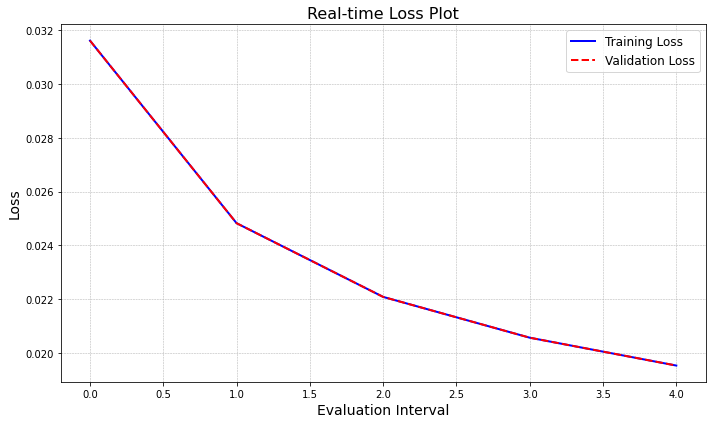

  0%|          | 405/1957075 [21:09<1703:49:51,  3.13s/it, Epoch=1, LR=9e-6, Train_Loss=0.0195]


KeyboardInterrupt: 

In [ ]:
train()

# **Test Bench**

---
## **Load Model**
---

In [ ]:
def load_model(model_path):
    # Load state dictionary from disk
    state_dict = torch.load(model_path)

    # Create a new state dictionary without the 'module.' prefix
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

    model = Transformer(
        vocab_size = VOCAB_SIZE,
        num_embed = EMBED_DIM,
        block_size = SEQ_LEN,
        num_heads = TRANSFORMER_HEADS,
        num_layers = TRANSFORMER_LAYERS)

    model.load_state_dict(new_state_dict)
    model.eval()

    return model

---
## **Create Songs**
---

In [ ]:
song_prefix = 'gameboy001_test'
model_name = 'Gameboy002_2023-09-19_04_18_e_8_s_400'
context_length = 64
song_length = 1024
block_size = 64

test_set = 0

for i in range(10):
    model_path = f'output/{model_name}.pt'
    torch.manual_seed(random.randint(1, 1_000_000))
    model = load_model(model_path).to(DEVICE)

    with open('encoding/0_newbarktown.npy', 'rb') as f:
        initial_idx = np.load(f)

    length = context_length
    initial_idx = torch.tensor([initial_idx.tolist()[length:length * 2]]).to(DEVICE)

    generated_sequence = model.generate(initial_idx, max_new_tokens=song_length, block_size=block_size).tolist()

    song_name = song_prefix + str(i * test_set)

    if not os.path.exists('songs'):
        os.makedirs('songs')

    tokenizer = REMIPlus()
    midi = tokenizer.tokens_to_midi(generated_sequence[0][length:])
    midi.dump(f'./songs/{song_name}.midi')
    print(f'Song {song_name} has been written.')

tensor([[126, 213, 312,  63, 117, 128, 284,  22, 124, 127, 296,  22, 124, 127,
         238,  50, 124, 132, 217, 312,  62, 117, 128, 284,  22, 124, 127, 296,
          22, 124, 132, 238,  46, 124, 132,   4, 374, 189, 312,  60, 117, 128,
         238,  54, 124, 132, 193, 312,  63, 117, 128, 284,  29, 123, 128, 296,
          29, 124, 128, 238,  46, 124, 131, 197]], device='cuda:0')
Song gameboy004_test0 has been written.
tensor([[126, 213, 312,  63, 117, 128, 284,  22, 124, 127, 296,  22, 124, 127,
         238,  50, 124, 132, 217, 312,  62, 117, 128, 284,  22, 124, 127, 296,
          22, 124, 132, 238,  46, 124, 132,   4, 374, 189, 312,  60, 117, 128,
         238,  54, 124, 132, 193, 312,  63, 117, 128, 284,  29, 123, 128, 296,
          29, 124, 128, 238,  46, 124, 131, 197]], device='cuda:0')
Song gameboy004_test1 has been written.
tensor([[126, 213, 312,  63, 117, 128, 284,  22, 124, 127, 296,  22, 124, 127,
         238,  50, 124, 132, 217, 312,  62, 117, 128, 284,  22, 124, 127,